In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import numpy as np
from PIL import Image
import cv2
import matplotlib.image as mpimg
import os
import scipy.ndimage as ndimage
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [3]:
#importing dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2273 files belonging to 10 classes.


In [34]:
#display dataset classes
class_names = dataset.class_names
class_names

['guava_diseased',
 'guava_healthy',
 'jamun_diseased',
 'jamun_healthy',
 'lemon_diseased',
 'lemon_healthy',
 'mango_diseased',
 'mango_healthy',
 'pomegranate_diseased',
 'pomegrenate_healthy']

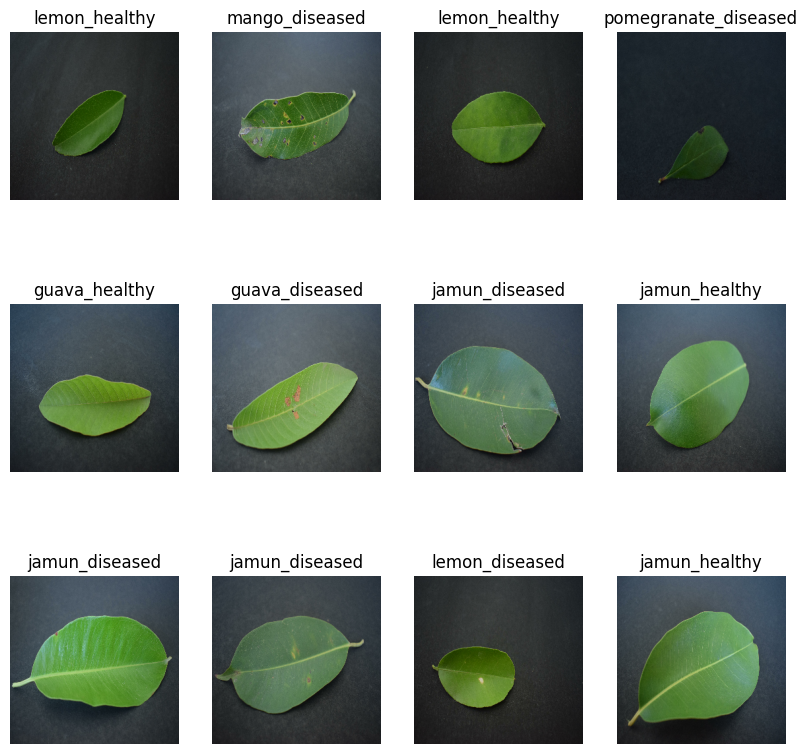

In [5]:
# Display Images

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
len(dataset)

72

In [7]:
#train dataset length calculation
train_size = 0.8
len(dataset)*train_size

57.6

In [8]:
train_ds = dataset.take(57)
len(train_ds)

57

In [9]:
#test dataset lenght calculation
test_ds = dataset.skip(57)
len(test_ds)

15

In [10]:
#validation dataset length calculation
val_size=0.1
len(dataset)*val_size

7.2

In [11]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [12]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [13]:
#dataset partition

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(dataset)

72

In [16]:
len(train_ds)

57

In [17]:
len(val_ds)

7

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
#pre-processing: image resizing and rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [21]:
normalized_dataset = dataset.map(lambda x, y: (resize_and_rescale(x), y))

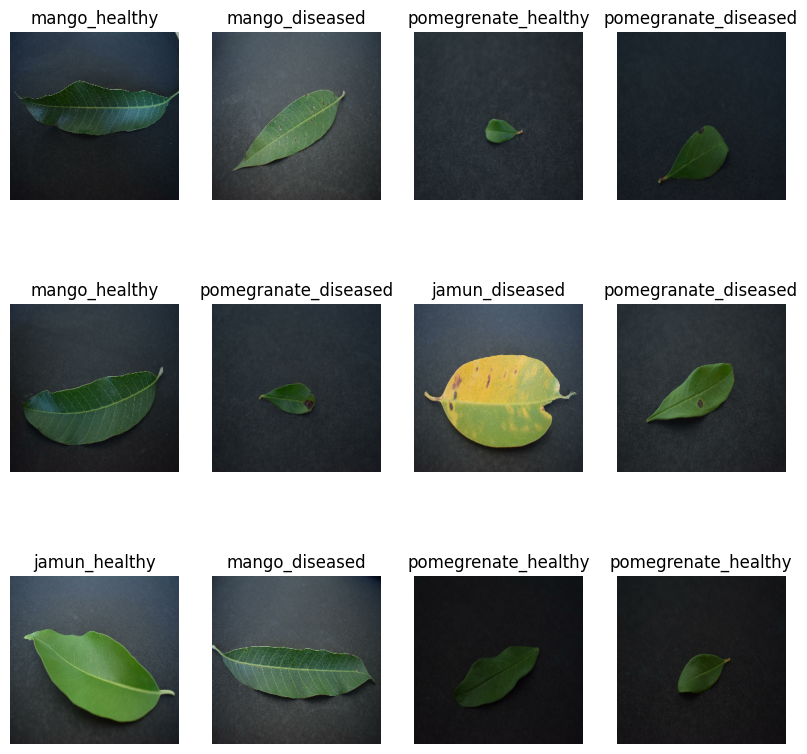

In [22]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [23]:
#pre-processing: data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
#Applying data augmentation to the dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

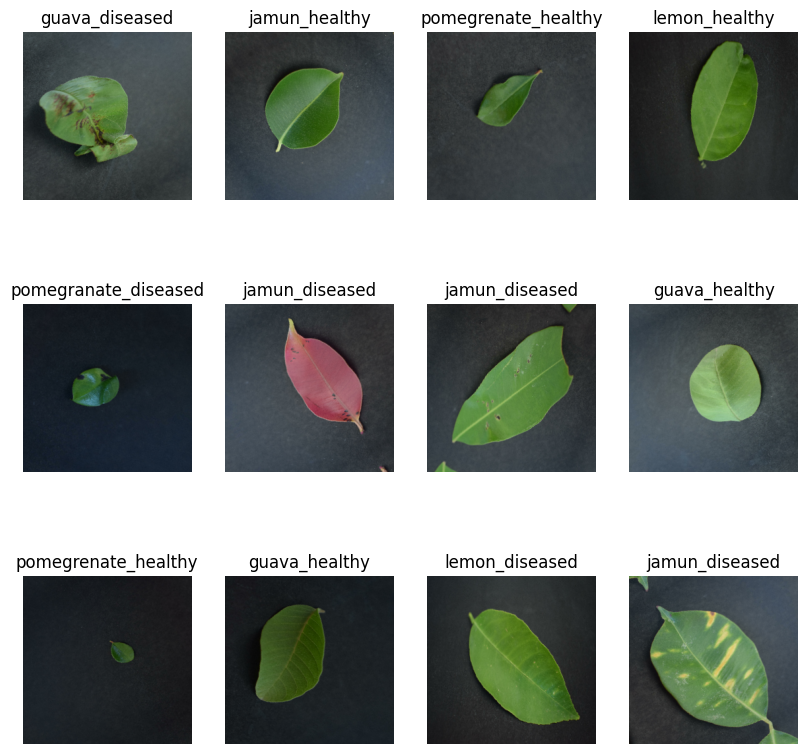

In [25]:
#disable shuffling to see augmentation result

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [37]:
#building CNN model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
totalClasses = 10

model = models.Sequential([
    #feature extraction
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    #classification
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(totalClasses, activation='softmax'),
])

model.build(input_shape=input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (32, 123008)             

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [31]:
#training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
57/57 [==============================] - 201s 4s/step - loss: 2.0594 - accuracy: 0.2423 - val_loss: 1.3400 - val_accuracy: 0.5446
Epoch 2/30
57/57 [==============================] - 100s 2s/step - loss: 1.3028 - accuracy: 0.5104 - val_loss: 0.9675 - val_accuracy: 0.6429
Epoch 3/30
57/57 [==============================] - 99s 2s/step - loss: 1.0476 - accuracy: 0.6058 - val_loss: 0.7978 - val_accuracy: 0.6652
Epoch 4/30
57/57 [==============================] - 114s 2s/step - loss: 0.9099 - accuracy: 0.6480 - val_loss: 0.7706 - val_accuracy: 0.7411
Epoch 5/30
57/57 [==============================] - 136s 2s/step - loss: 0.8549 - accuracy: 0.6842 - val_loss: 0.6160 - val_accuracy: 0.8170
Epoch 6/30
57/57 [==============================] - 134s 2s/step - loss: 0.6798 - accuracy: 0.7555 - val_loss: 0.6171 - val_accuracy: 0.7411
Epoch 7/30
57/57 [==============================] - 191s 3s/step - loss: 0.6435 - accuracy: 0.7610 - val_loss: 0.4996 - val_accuracy: 0.8036
Epoch 8/30
57/

In [29]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 67s 376ms/step - loss: 2.3093 - accuracy: 0.0978


In [33]:
scores2 = model.evaluate(train_ds)

57/57 [==============================] - 28s 477ms/step - loss: 0.2110 - accuracy: 0.9238


In [34]:
scores3 = model.evaluate(val_ds)

7/7 [==============================] - 2s 313ms/step - loss: 0.2739 - accuracy: 0.9018


In [35]:
score4 = model.evaluate(dataset)

72/72 [==============================] - 75s 941ms/step - loss: 0.2772 - accuracy: 0.9041


In [36]:
scores

[0.2349749058485031, 0.92578125]

In [37]:
scores2

[0.2110190987586975, 0.9237938523292542]

In [38]:
scores3

[0.27387669682502747, 0.9017857313156128]

In [39]:
score4

[0.2771509885787964, 0.9040915369987488]

NameError: name 'acc' is not defined

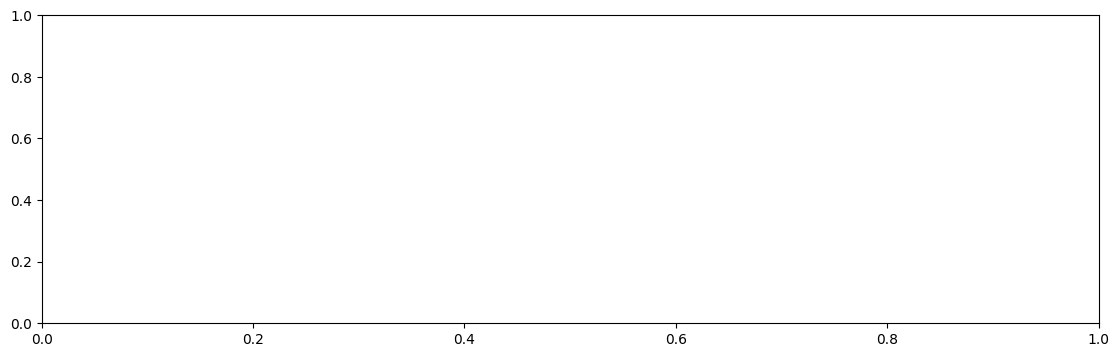

In [35]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

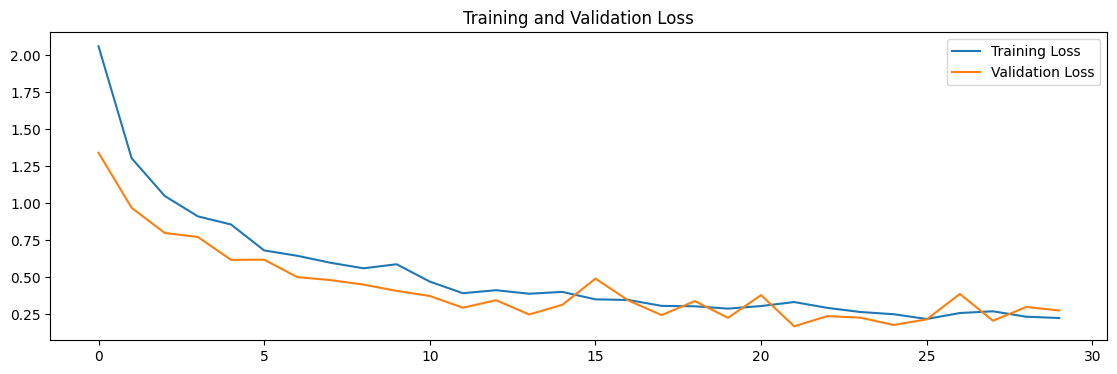

In [42]:
plt.figure(figsize=(30, 4))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: jamun_healthy
1/1 [==============================] - 1s 622ms/step
predicted label: lemon_healthy


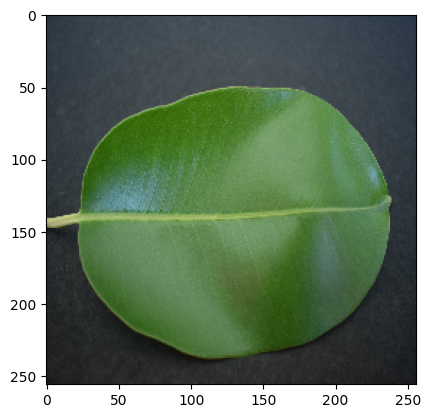

In [32]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [46]:
y_pred_prob = model.predict(test_ds)

8/8 [==============================] - 3s 365ms/step


In [47]:
#predicted probability
print(y_pred_prob)

[[3.6329818e-03 1.9803236e-05 1.1959554e-06 ... 8.8646965e-09
  4.2825272e-09 1.0242815e-06]
 [2.0311427e-05 7.6822807e-06 7.5036766e-08 ... 9.9983895e-01
  4.6270739e-05 4.0648025e-05]
 [2.4430363e-03 1.3685423e-03 3.5097304e-04 ... 1.6326555e-06
  3.7300001e-06 3.6075102e-07]
 ...
 [1.4718965e-04 4.1383573e-05 8.0887697e-10 ... 6.9464823e-11
  3.4994627e-09 9.9440902e-01]
 [7.6564817e-07 2.6138526e-04 1.7959457e-11 ... 9.3207331e-05
  9.5501173e-01 4.4632874e-02]
 [4.2458792e-06 4.9953506e-04 6.2116419e-09 ... 1.7378073e-04
  9.9127263e-01 8.0495104e-03]]


In [48]:
y_pred_labels = np.argmax(y_pred_prob, axis=1)

In [49]:
#predicted labels
print(y_pred_labels)

[6 7 6 0 2 3 3 4 2 3 6 0 9 3 0 5 9 9 6 2 9 7 8 5 8 8 0 2 8 1 6 8 5 9 6 9 4
 0 5 7 8 1 0 6 0 1 2 6 9 0 2 6 0 2 9 0 6 6 1 3 1 9 6 5 2 2 9 2 6 6 1 5 6 6
 2 3 8 0 7 7 1 1 8 6 2 9 8 0 6 9 2 1 8 2 9 9 6 2 3 4 8 7 9 0 8 9 9 2 9 9 8
 2 4 1 2 9 8 8 8 2 0 8 2 8 6 1 8 0 3 2 5 9 1 2 8 9 9 2 8 0 6 0 8 6 2 2 6 9
 6 5 5 1 2 9 2 2 9 3 3 1 3 2 7 6 8 0 8 1 5 5 2 3 5 9 0 1 6 5 1 2 8 6 3 6 5
 6 9 3 0 9 0 0 3 9 2 7 3 6 0 9 1 1 6 7 7 5 2 6 2 9 9 9 9 5 0 1 7 2 1 1 1 2
 0 2 0 2 5 1 1 3 0 6 8 5 6 1 2 1 3 9 6 0 3 2 5 9 2 5 1 1 9 9 8 9 8 8]


In [50]:
y_true_labels = np.concatenate([y for x, y in test_ds], axis=0)

In [51]:
#true labels
print(y_true_labels)

[3 2 4 9 1 2 8 9 9 2 8 0 6 0 8 6 2 2 6 8 6 4 5 1 2 8 2 2 9 3 3 1 3 2 7 6 8
 0 8 1 5 5 2 3 5 9 0 1 6 5 1 2 8 6 3 6 5 6 9 3 0 9 3 0 6 2 3 4 8 7 9 0 8 9
 9 2 9 9 8 2 4 1 2 9 8 8 8 2 0 8 2 8 6 1 8 0 3 9 3 7 3 6 0 9 1 1 6 7 7 5 2
 6 2 9 8 9 9 5 0 1 7 2 1 1 1 2 0 2 0 2 5 1 1 3 0 6 8 5 6 1 2 1 3 9 6 0 3 2
 4 9 2 5 1 1 9 9 8 9 8 8 2 2 9 2 6 3 1 5 6 6 2 3 8 0 7 7 1 1 8 6 2 9 8 2 6
 9 2 1 8 2 9 9 6 7 6 0 3 3 2 4 2 3 6 3 9 3 3 4 9 9 6 2 9 7 8 5 8 8 0 2 8 1
 6 8 5 9 6 9 4 0 5 7 8 1 0 5 0 1 2 3 9 0 2 9 0 3 9 0 6 6 1 3 1 9 6 5]


In [52]:
cm = confusion_matrix(y_true_labels, y_pred_labels)

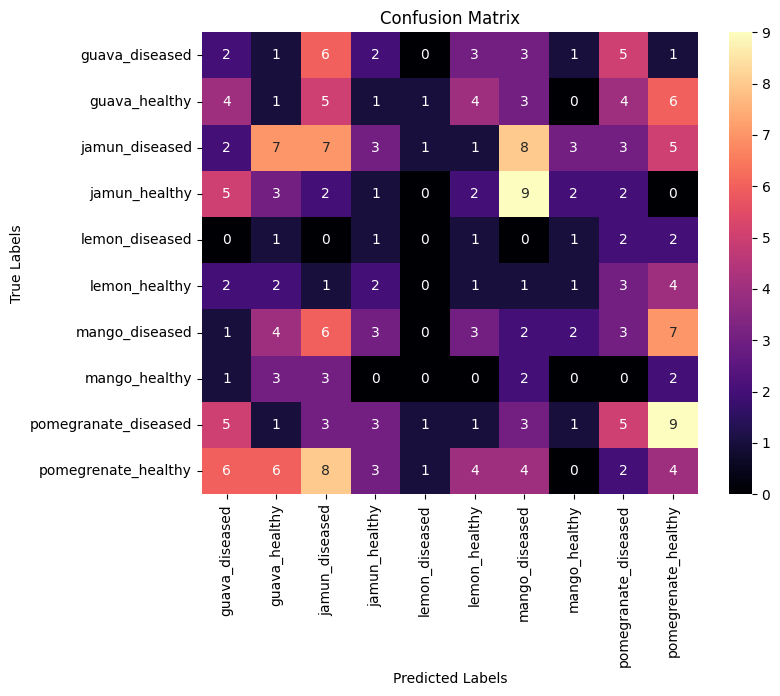

In [65]:
#disable shuffling dataset before printing confusion matrix

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="magma", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:
def calculate_accuracy(confusion_matrix):
    diagonal_sum = np.trace(confusion_matrix)
    total_sum = np.sum(confusion_matrix)
    accuracy = diagonal_sum / total_sum
    return accuracy

accuracy = calculate_accuracy(cm)
print("Accuracy:", accuracy)

Accuracy: 0.109375


In [56]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#accuracy for each class
accuracy_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    TN = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    accuracy_per_class.append(accuracy)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Accuracy for class '{class_name}': {accuracy_per_class[class_index]}")


8/8 [==============================] - 2s 289ms/step
Accuracy for class 'guava_diseased': 0.8046875
Accuracy for class 'guava_healthy': 0.8046875
Accuracy for class 'jamun_diseased': 0.74609375
Accuracy for class 'jamun_healthy': 0.83984375
Accuracy for class 'lemon_diseased': 0.953125
Accuracy for class 'lemon_healthy': 0.87109375
Accuracy for class 'mango_diseased': 0.7578125
Accuracy for class 'mango_healthy': 0.9140625
Accuracy for class 'pomegranate_diseased': 0.78515625
Accuracy for class 'pomegrenate_healthy': 0.734375


In [57]:
def calculate_specificity(confusion_matrix):
    true_negatives = confusion_matrix[0, 0]
    false_positives = confusion_matrix[0, 1]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

specificity = calculate_specificity(cm)
print("Specificity:", specificity)

Specificity: 0.5


In [58]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#specificity for each class
specificity_per_class = []
for class_index in range(len(class_names)):
    TN = np.sum(np.delete(np.delete(cm, class_index, axis=0), class_index, axis=1))
    FP = np.sum(cm[:, class_index]) - cm[class_index, class_index]
    specificity = TN / (TN + FP)
    specificity_per_class.append(specificity)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Specificity for class '{class_name}': {specificity_per_class[class_index]}")


8/8 [==============================] - 2s 278ms/step
Specificity for class 'guava_diseased': 0.9051724137931034
Specificity for class 'guava_healthy': 0.9162995594713657
Specificity for class 'jamun_diseased': 0.8842592592592593
Specificity for class 'jamun_healthy': 0.9565217391304348
Specificity for class 'lemon_diseased': 0.9838709677419355
Specificity for class 'lemon_healthy': 0.9456066945606695
Specificity for class 'mango_diseased': 0.8933333333333333
Specificity for class 'mango_healthy': 0.9591836734693877
Specificity for class 'pomegranate_diseased': 0.9285714285714286
Specificity for class 'pomegrenate_healthy': 0.8577981651376146


In [59]:
def calculate_sensitivity(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_negatives = confusion_matrix[1, 0]
    sensitivity = true_positives / (true_positives + false_negatives)
    return sensitivity

sensitivity = calculate_sensitivity(cm)
print("Sensitivity:", sensitivity)

Sensitivity: 0.6666666666666666


In [60]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#sensitivity for each class
sensitivity_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FN = np.sum(cm[class_index, :]) - TP
    P = np.sum(cm[:, class_index])
    sensitivity = TP / (TP + FN)
    sensitivity_per_class.append(sensitivity)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Sensitivity for class '{class_name}': {sensitivity_per_class[class_index]}")


8/8 [==============================] - 2s 275ms/step
Sensitivity for class 'guava_diseased': 0.125
Sensitivity for class 'guava_healthy': 0.06896551724137931
Sensitivity for class 'jamun_diseased': 0.075
Sensitivity for class 'jamun_healthy': 0.11538461538461539
Sensitivity for class 'lemon_diseased': 0.0
Sensitivity for class 'lemon_healthy': 0.0
Sensitivity for class 'mango_diseased': 0.12903225806451613
Sensitivity for class 'mango_healthy': 0.0
Sensitivity for class 'pomegranate_diseased': 0.21875
Sensitivity for class 'pomegrenate_healthy': 0.18421052631578946


In [61]:
def calculate_precision(confusion_matrix):
    true_positives = confusion_matrix[1, 1]
    false_positives = confusion_matrix[0, 1]
    precision = true_positives / (true_positives + false_positives)
    return precision

precision = calculate_precision(cm)
print("Precision:", precision)

Precision: 0.2857142857142857


In [62]:
#predictions from the model
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

#true labels
y_true = np.concatenate([y for _, y in test_ds], axis=0)

#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#precision for each class
precision_per_class = []
for class_index in range(len(class_names)):
    TP = cm[class_index, class_index]
    FP = np.sum(cm[:, class_index]) - TP
    P = np.sum(cm[class_index, :])
    precision = TP / (TP + FP)
    precision_per_class.append(precision)

# Print
for class_index, class_name in enumerate(class_names):
    print(f"Precision for class '{class_name}': {precision_per_class[class_index]}")


8/8 [==============================] - 2s 274ms/step
Precision for class 'guava_diseased': 0.07142857142857142
Precision for class 'guava_healthy': 0.034482758620689655
Precision for class 'jamun_diseased': 0.17073170731707318
Precision for class 'jamun_healthy': 0.05263157894736842
Precision for class 'lemon_diseased': 0.0
Precision for class 'lemon_healthy': 0.05
Precision for class 'mango_diseased': 0.05714285714285714
Precision for class 'mango_healthy': 0.0
Precision for class 'pomegranate_diseased': 0.1724137931034483
Precision for class 'pomegrenate_healthy': 0.1
